In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import ResNet50, EfficientNetB0
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import (
    Input, Dense, Dropout, LayerNormalization,
    GlobalAveragePooling2D, Reshape, MultiHeadAttention,
    Add, Activation, Concatenate, Lambda
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight

# dataset directory
dataset_dir = "../real-dataset/compiled/"

# load and preprocess the dataset without batching
data = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    labels='inferred',
    label_mode='int',
    image_size=(224, 224),
    batch_size=None,  # ← KEY CHANGE: No batching yet
    shuffle=True,
    seed=42  # For reproducibility
)

Found 545 files belonging to 5 classes.


In [3]:
# split the dataset into train, validation, and test sets
def split_dataset(dataset, train_size=0.7, val_size=0.2, batch_size=32):
    total_size = dataset.cardinality().numpy()

    train_count = int(total_size * train_size)
    val_count = int(total_size * val_size)
    test_count = total_size - train_count - val_count

    # Split BEFORE batching
    train_dataset = dataset.take(train_count).batch(batch_size)
    val_test_dataset = dataset.skip(train_count)
    val_dataset = val_test_dataset.take(val_count).batch(batch_size)
    test_dataset = val_test_dataset.skip(val_count).batch(batch_size)

    print(f"Dataset split finished: {train_count} train, {val_count} val, {test_count} test samples.")
    return train_dataset, val_dataset, test_dataset

train, val, test = split_dataset(data, batch_size=32)

# Prefetch for performance
train = train.prefetch(tf.data.AUTOTUNE)
val = val.prefetch(tf.data.AUTOTUNE)
test = test.prefetch(tf.data.AUTOTUNE)

Dataset split finished: 381 train, 109 val, 55 test samples.


In [4]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Collect all labels from the training set
train_labels = []
for _, labels in train.unbatch():  # unbatch to get single samples
    train_labels.append(labels.numpy())

train_labels = np.array(train_labels)
print(f"Collected {len(train_labels)} training labels.")

# Compute class weights
classes = np.unique(train_labels)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=train_labels)
class_weight_dict = dict(zip(classes, class_weights))

# Debug output
print("class weights calculation:")
for cls, weight in class_weight_dict.items():
    print(f"  Class {cls}: {weight:.4f}")

Collected 381 training labels.
class weights calculation:
  Class 0: 0.8562
  Class 1: 0.6145
  Class 2: 1.6933
  Class 3: 1.8585
  Class 4: 0.9293


Counting original training set classes (this may take a moment)...
Creating augmented dataset and concatenating...
Counting augmented training set classes...

--- Augmentation Impact Analysis ---
Class                | Before     | After      | Increase  
-------------------------------------------------------
First Degree         | 98         | 186        | 88        
Second Degree        | 110        | 228        | 118       
Third Degree         | 44         | 85         | 41        
Fourth Degree        | 37         | 78         | 41        
Normal Skin          | 92         | 185        | 93        
-------------------------------------------------------


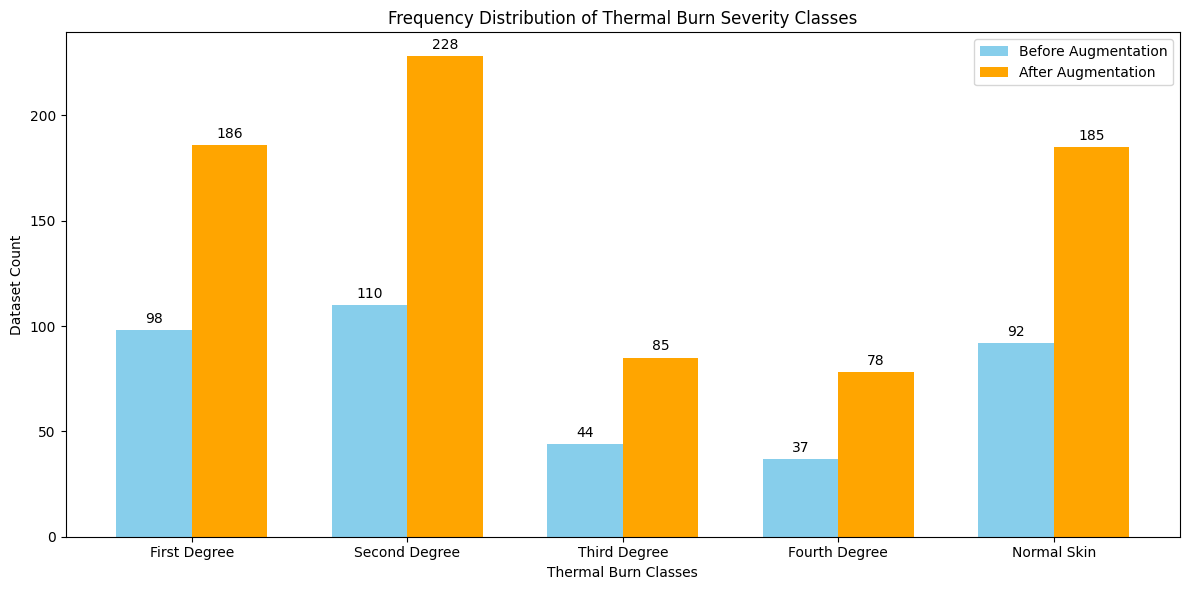

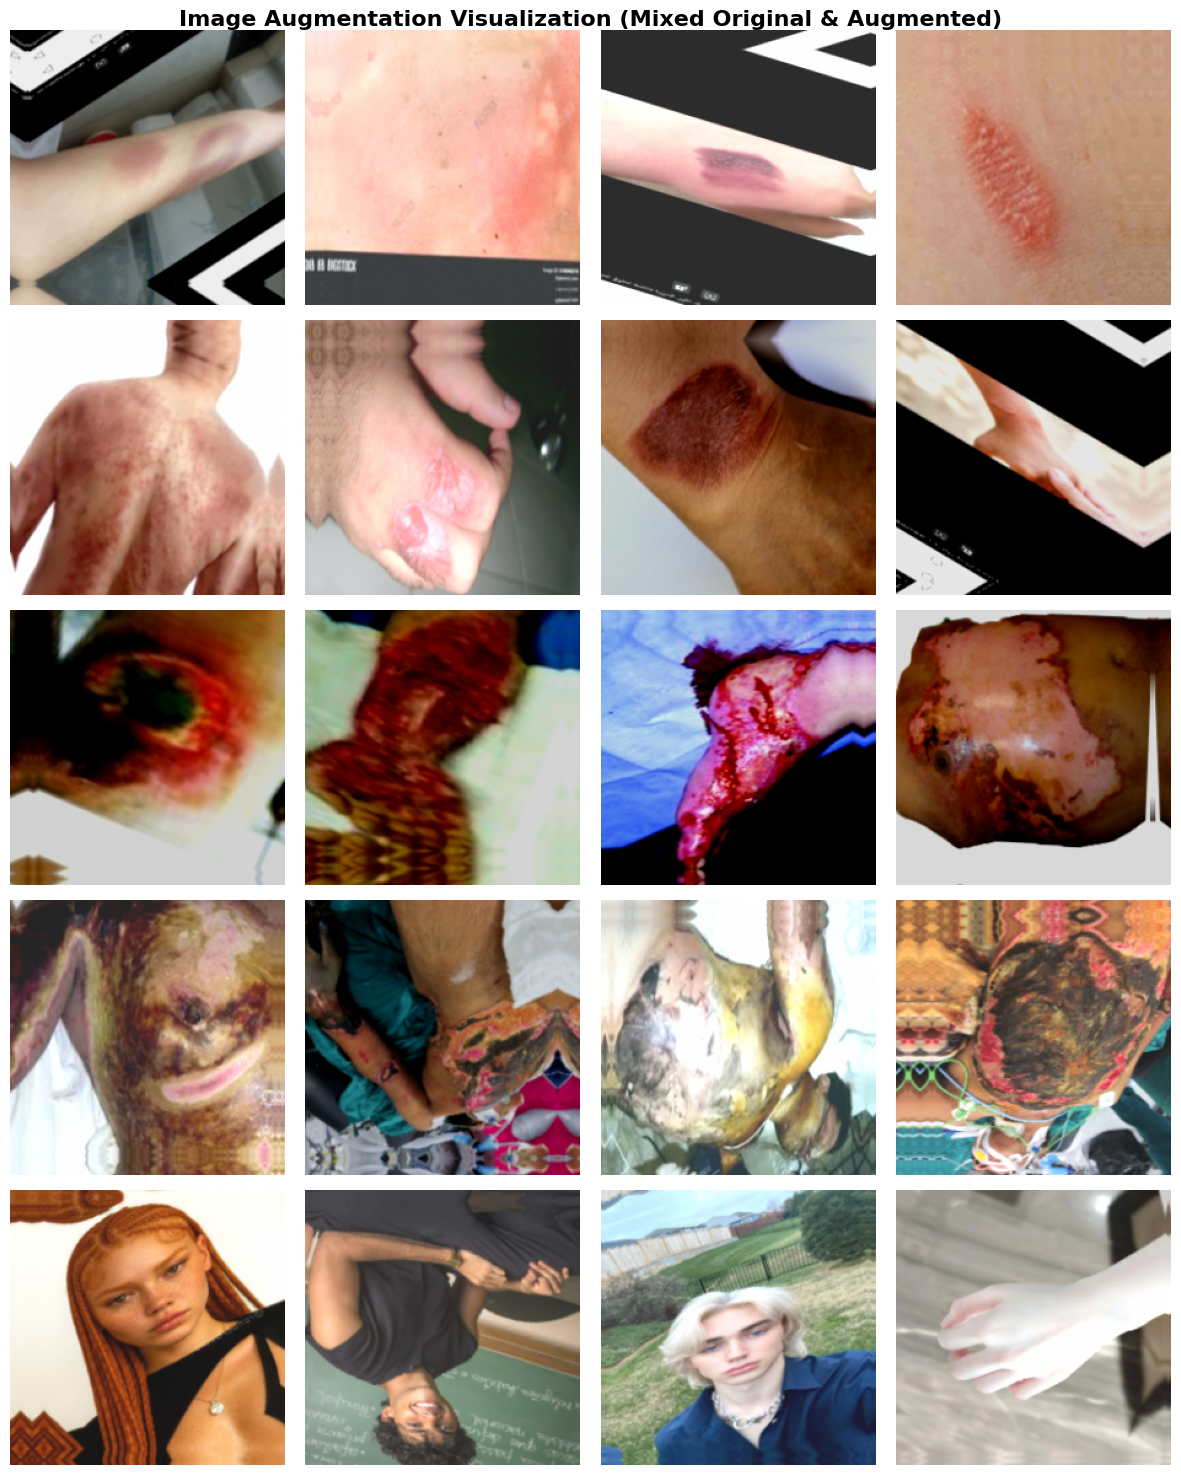

In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random

# Define class labels
class_labels = {
    0: 'First Degree',
    1: 'Second Degree',
    2: 'Third Degree',
    3: 'Fourth Degree',
    4: 'Normal Skin'
}

# Function to count samples per class
def get_class_counts(dataset):
    counts = {k: 0 for k in class_labels.keys()}
    # Iterate over batches
    for _, batch_labels in dataset:
        for label in batch_labels.numpy():
            label = int(label)
            if label in counts:
                counts[label] += 1
    return counts

print("Counting original training set classes (this may take a moment)...")
counts_before = get_class_counts(train)

# Advanced augmentation pipeline
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomFlip("vertical"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomTranslation(0.1, 0.1),
    tf.keras.layers.RandomContrast(0.2),
    tf.keras.layers.RandomBrightness(0.2),
    tf.keras.layers.GaussianNoise(0.01),
], name='data_augmentation')

# Apply augmentation
# We create a new dataset with augmented images and concatenate it to the original
print("Creating augmented dataset and concatenating...")
augmented_train = train.map(
    lambda x, y: (data_augmentation(x, training=True), y),
    num_parallel_calls=tf.data.AUTOTUNE
)

# Concatenate original and augmented datasets
# This effectively doubles the dataset size
train = train.concatenate(augmented_train)

# Shuffle the combined dataset
train = train.shuffle(buffer_size=1000).prefetch(tf.data.AUTOTUNE)

print("Counting augmented training set classes...")
counts_after = get_class_counts(train)

# Display comparison
print("\n--- Augmentation Impact Analysis ---")
print(f"{'Class':<20} | {'Before':<10} | {'After':<10} | {'Increase':<10}")
print("-" * 55)
for cls in class_labels:
    name = class_labels[cls]
    before = counts_before[cls]
    after = counts_after[cls]
    print(f"{name:<20} | {before:<10} | {after:<10} | {after - before:<10}")
print("-" * 55)

# Bar Graph Visualization
labels = [class_labels[i] for i in range(len(class_labels))]
before_values = [counts_before[i] for i in range(len(class_labels))]
after_values = [counts_after[i] for i in range(len(class_labels))]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, before_values, width, label='Before Augmentation', color='skyblue')
rects2 = ax.bar(x + width/2, after_values, width, label='After Augmentation', color='orange')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Dataset Count')
ax.set_xlabel('Thermal Burn Classes')
ax.set_title('Frequency Distribution of Thermal Burn Severity Classes')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()
plt.show()

# Visualize 4 random augmented images per category
num_per_class = 4
samples = {k: [] for k in class_labels.keys()}

# Note: We unbatch to visualize individual images
for images, labels in train.unbatch().take(500): # Take a subset to speed up
    label = int(labels.numpy())
    if label in samples and len(samples[label]) < num_per_class:
        samples[label].append(images)
    # Stop when all classes have enough samples
    if all(len(v) == num_per_class for v in samples.values()):
        break

plt.figure(figsize=(num_per_class * 3, len(class_labels) * 3))
for class_idx, (cat, imgs) in enumerate(samples.items()):
    for i, img in enumerate(imgs):
        if i < len(imgs):
            ax = plt.subplot(len(class_labels), num_per_class, class_idx * num_per_class + i + 1)
            img = tf.clip_by_value(img, 0, 255)
            plt.imshow(img.numpy().astype("uint8"))
            if i == 0:
                ax.set_ylabel(class_labels[cat], fontsize=12, fontweight='bold')
            plt.axis("off")
plt.suptitle("Image Augmentation Visualization (Mixed Original & Augmented)", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [7]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import (Dense, Dropout, LayerNormalization,
                                     MultiHeadAttention, Add, Input, Reshape, GlobalAveragePooling1D)
from tensorflow.keras.models import Model

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.1):
    # Attention block
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(num_heads=num_heads, key_dim=head_size, dropout=dropout)(x, x)
    x = Dropout(dropout)(x)
    res = Add()([x, inputs])

    # Feed-forward block
    x = LayerNormalization(epsilon=1e-6)(res)
    x = Dense(ff_dim, activation="relu")(x)
    x = Dropout(dropout)(x)
    x = Dense(inputs.shape[-1])(x)
    return Add()([x, res])

def build_hybrid_model(input_shape=(224, 224, 3), num_classes=5):
    inputs = Input(shape=input_shape)

    # CNN Backbone (feature extractor)
    base_model = ResNet50(include_top=False, weights="imagenet", input_tensor=inputs, name="resnet50")
    base_model.trainable = False   # fine-tune later if needed

    x = base_model.output  # shape: (7, 7, 2048)
    x = Reshape((49, 2048))(x)  # Flatten spatial grid into sequence

    # Transformer blocks
    for _ in range(2):  # can increase for more power
        x = transformer_encoder(x, head_size=64, num_heads=4, ff_dim=256, dropout=0.1)

    # Pool transformer outputs
    x = GlobalAveragePooling1D()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation="softmax")(x)

    model = Model(inputs, outputs)
    return model

# Usage
model = build_hybrid_model(num_classes=5)
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# callbacks for training
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6
)

In [ ]:
history = model.fit(
    train,
    validation_data=val,
    epochs=20,
    class_weight=class_weight_dict,
    callbacks=[early_stopping, reduce_lr]
)

In [ ]:
import matplotlib.pyplot as plt

# Plot accuracy and loss after training
plt.figure(figsize=(10, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
model.save('../real-checkpoints/model_vanilla.h5')

In [ ]:
# Stage 2: Unfreeze top ResNet layers (last 30 layers)
resnet_layers = [layer for layer in model.layers if layer.name.startswith('conv') or layer.name.startswith('pool')]
for layer in resnet_layers[-30:]:
    layer.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_stage2 = model.fit(
    train,
    validation_data=val,
    epochs=10,
    class_weight=class_weight_dict,
    callbacks=[early_stopping, reduce_lr]
)

In [ ]:
model.save('../real-checkpoints/finetunes1.h5')

In [ ]:
# Stage 2: Unfreeze top ResNet layers (last 60 layers)
resnet_layers = [layer for layer in model.layers if layer.name.startswith('conv') or layer.name.startswith('pool')]
for layer in resnet_layers[-60:]:
    layer.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(2e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_stage2 = model.fit(
    train,
    validation_data=val,
    epochs=10,
    class_weight=class_weight_dict,
    callbacks=[early_stopping, reduce_lr]
)

In [ ]:
model.save('../real-checkpoints/finetunes2.h5')

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, Accuracy

pre = Precision()
re = Recall()
acc = Accuracy()

# Evaluate the model on the test set
for batch in test.as_numpy_iterator():
    X, y = batch  # unpack the batch
    yhat = model.predict(X)  # get predictions (probabilities)
    yhat_classes = np.argmax(yhat, axis=1)  # convert to class indices

    # update metrics
    pre.update_state(y, yhat_classes)
    re.update_state(y, yhat_classes)
    acc.update_state(y, yhat_classes)

# print results
print(f"Test Precision: {pre.result().numpy():.4f}")
print(f"Test Recall: {re.result().numpy():.4f}")
print(f"Test Accuracy: {acc.result().numpy():.4f}")

In [ ]:
#Unfreeze top ResNet layers (last 90 layers)
resnet_layers = [layer for layer in model.layers if layer.name.startswith('conv') or layer.name.startswith('pool')]
for layer in resnet_layers[-90:]:
    layer.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(2e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_stage2 = model.fit(
    train,
    validation_data=val,
    epochs=10,
    class_weight=class_weight_dict,
    callbacks=[early_stopping, reduce_lr]
)

In [ ]:
model.save('../real-checkpoints/finetunes3.h5')

In [ ]:
resnet_layers = [layer for layer in model.layers if layer.name.startswith('conv') or layer.name.startswith('pool')]
for layer in resnet_layers[-150:]:
    layer.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(2e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_stage2 = model.fit(
    train,
    validation_data=val,
    epochs=20,
    class_weight=class_weight_dict,
    callbacks=[early_stopping, reduce_lr]
)

In [ ]:
pre = Precision()
re = Recall()
acc = Accuracy()

# evaluate the model on the test set
for batch in test.as_numpy_iterator():
    X, y = batch  # unpack the batch
    yhat = model.predict(X)  # get predictions (probabilities)
    yhat_classes = np.argmax(yhat, axis=1)  # convert to class indices

    # update metrics
    pre.update_state(y, yhat_classes)
    re.update_state(y, yhat_classes)
    acc.update_state(y, yhat_classes)

# print results
print(f"Precision: {pre.result().numpy():.4f}")
print(f"Recall: {re.result().numpy():.4f}")
print(f"Accuracy: {acc.result().numpy():.4f}")

In [ ]:
model.save('../real-checkpoints/finetunes4.h5')

In [ ]:
resnet_layers = [layer for layer in model.layers if layer.name.startswith('conv') or layer.name.startswith('pool')]
for layer in resnet_layers[-200:]:
    layer.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-6),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_stage2 = model.fit(
    train,
    validation_data=val,
    epochs=20,
    class_weight=class_weight_dict,
    callbacks=[early_stopping, reduce_lr]
)

In [ ]:
model.save('../real-checkpoints/finetunes5.h5')

In [ ]:
from tensorflow.keras.models import load_model

# Load the the best model
model = load_model('../real-checkpoints/finetunes3.h5')

pre = Precision()
re = Recall()
acc = Accuracy()

# evaluate the model on the test set
for batch in test.as_numpy_iterator():
    X, y = batch  # unpack the batch
    yhat = model.predict(X)  # get predictions (probabilities)
    yhat_classes = np.argmax(yhat, axis=1)  # convert to class indices

    # update metrics
    pre.update_state(y, yhat_classes)
    re.update_state(y, yhat_classes)
    acc.update_state(y, yhat_classes)

# print results
print(f"Precision: {pre.result().numpy():.4f}")
print(f"Recall: {re.result().numpy():.4f}")
print(f"Accuracy: {acc.result().numpy():.4f}")

In [ ]:
# Load the the best model
model = load_model('../real-checkpoints/finetunes3.h5')

for layer in model.layers:
    if hasattr(layer, 'trainable'):
        layer.trainable = False
# Unfreeze transformer layers (those after ResNet output)
for layer in model.layers:
    if 'multi_head_attention' in layer.name or 'dense' in layer.name or 'dropout' in layer.name or 'layer_normalization' in layer.name:
        layer.trainable = True

# Recompile with a low learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Fine-tune transformer layers
history_transformer = model.fit(
    train,
    validation_data=val,
    epochs=10,
    class_weight=class_weight_dict,
    callbacks=[early_stopping, reduce_lr]
)


In [ ]:
pre = Precision()
re = Recall()
acc = Accuracy()

# evaluate the model on the test set
for batch in test.as_numpy_iterator():
    X, y = batch  # unpack the batch
    yhat = model.predict(X)  # get predictions (probabilities)
    yhat_classes = np.argmax(yhat, axis=1)  # convert to class indices

    # update metrics
    pre.update_state(y, yhat_classes)
    re.update_state(y, yhat_classes)
    acc.update_state(y, yhat_classes)

# print results
print(f"Precision: {pre.result().numpy():.4f}")
print(f"Recall: {re.result().numpy():.4f}")
print(f"Accuracy: {acc.result().numpy():.4f}")

In [ ]:
model.save('../real-checkpoints/finalfinetuning.h5')

In [ ]:
# Load the the best model
model = load_model('../real-checkpoints/finetunes3.h5')

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Load the the best model
model = load_model('../real-checkpoints/finalfinetuning.h5')

# Initialize lists to store true and predicted labels
y_true = []
y_pred = []

# Iterate through the test dataset to get predictions
print("Generating predictions on test set...")
for images, labels in test:
    predictions = model.predict(images, verbose=0)
    predicted_classes = np.argmax(predictions, axis=1)

    y_true.extend(labels.numpy())
    y_pred.extend(predicted_classes)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Calculate overall metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Overall Test Accuracy: {accuracy:.4f}")
print(f"Overall Weighted Precision: {precision:.4f}")
print(f"Overall Weighted F1 Score: {f1:.4f}")

# Define class names for better readability
class_names = ['First Degree', 'Second Degree', 'Third Degree', 'Fourth Degree', 'Normal Skin']

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Print detailed Classification Report
print("\nDetailed Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))